# **Monitoramento Inteligente de Vagas de Estacionamento:** Computational Vision e YOLOv8
-----------------
## **Introdução**
A busca por uma vaga disponível em estacionamentos, seja em shoppings, supermercados, aeroportos ou em qualquer lugar movimentado, muitas vezes se transforma em uma tarefa árdua e demorada para os motoristas. A incessante circulação em busca de um espaço vago não apenas gera frustração, mas também contribui para o congestionamento e o desperdício de tempo.

A Visão Computacional, um campo interdisciplinar em ascensão, oferece soluções inovadoras para esse problema. Ela capacita sistemas de computador a interpretar e compreender o mundo visual, abrindo caminho para uma série de aplicações valiosas, incluindo a detecção de objetos, o reconhecimento facial, o rastreamento de movimento e a análise de imagens. Combinada com técnicas de Aprendizado de Máquina, a Visão Computacional se destaca na detecção de padrões complexos.

Neste contexto, apresentamos o projeto "Detecção de Vagas Disponíveis em Estacionamentos com YOLOv8". YOLOv8 é uma rede neural convolucional que representa o estado da arte da Visão Computacional, sendo uma poderosa ferramenta para análise de dados visuais.

## **Objetivo do Projeto**
O principal objetivo deste projeto é criar um sistema de monitoramento de estacionamento que seja capaz de monitorar a disponibilidade de vagas e sua localização por meio de uma análise de vídeo. Para atingir esse objetivo, o projeto busca cumprir os seguintes objetivos específicos:

**Detecção de Veículos:** Implementar um sistema de reconhecimento e detecção de veículos nos frames do vídeo, identificando a presença de carros no estacionamento.

**Localização das Vagas:** Obter as coordenadas de pixels que representam as vagas no estacionamento, permitindo a identificação precisa de sua localização.

**Correlação Carro-Vaga:** Estabelecer uma correlação entre as detecções de veículos e as coordenadas das vagas, permitindo determinar a disponibilidade das vagas de estacionamento.

**Identificação Visual das Vagas:** Criar um sistema de identificação visual das vagas disponíveis, indicando de forma clara e intuitiva aos motoristas onde podem encontrar um espaço vago. Além disso, identificar os tipos de vagas, como vagas para pessoas com deficiência (PcD) ou vagas regulares.

## **Benefícios Esperados**
Esse projeto tem o potencial de proporcionar uma série de benefícios, não apenas para os motoristas, mas também para a gestão de estacionamentos e para a sociedade como um todo. Ao tornar o processo de encontrar vagas mais eficiente, o projeto busca:

- Reduzir o estresse e o tempo gasto pelos motoristas em busca de vagas.
- Contribuir para a diminuição do congestionamento de tráfego em estacionamentos.
- Melhorar a gestão de estacionamentos, permitindo um uso mais eficiente dos espaços disponíveis.
- Promover a inclusão, identificando vagas reservadas para pessoas com deficiência.

-------------------


## **Importações**

In [ ]:
!nvidia-smi # verifica informações da GPU da NVIDIA

Tue Sep 12 01:42:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ultralytics==8.0.172 # versão a qual o projeto foi desenvolvido

from IPython.display import Image, Video, clear_output
clear_output()

import ultralytics

print(ultralytics.checks(), ultralytics.__version__)

Ultralytics YOLOv8.0.172 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.2/78.2 GB disk)


None 8.0.172


A Ultralytics é a biblioteca que fornece os modelos de CNN YOLO.

In [ ]:
!pip install supervision==0.14.0 # versão a qual o projeto foi desenvolvido

clear_output()

import cv2
import supervision as sv
print("Supervision", sv.__version__)

Supervision 0.14.0


A Supervision é uma biblioteca de código aberto da Roboflow que executa diversas tarefas voltada para visão computacional.

In [ ]:
!pip install rtree

clear_output()

## **Pré-processamento de vídeo**

Já idealizando um ambiente de produção, é crucial pensar num pré-processamento de vídeo, definindo formatos

In [ ]:
# download do vídeo para o ambiente colab
import requests
import os

HOME = os.getcwd()

# ReferÊncia: vídeo de Oleh Shtohryn no Pexels: https://www.pexels.com/pt-br/video/aereo-antena-automovel-carro-5587732/
video_url = "https://www.pexels.com/pt-br/download/video/5587732/" # downlaod direto

response = requests.get(video_url)

# verifique se o download foi bem-sucedido (código de status 200)
if response.status_code == 200:
    # especifique o local onde deseja salvar o vídeo no Google Drive
    download_location = f"{HOME}/video_estacionamento.mp4"

    # Abra o arquivo e escreva o conteúdo do vídeo
    with open(download_location, 'wb') as video_file:
        video_file.write(response.content)

    print("Vídeo baixado com sucesso!")
else:
    print("Falha ao baixar o vídeo. Verifique a URL e a conexão com a internet.")

Falha ao baixar o vídeo. Verifique a URL e a conexão com a internet.


In [ ]:
# treinamento será salvo no drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# caminho para o vídeo
PATH_VIDEO = "/content/drive/MyDrive/Colab/video_estacionamento.mp4"
print(PATH_VIDEO)

/content/drive/MyDrive/Colab/video_estacionamento.mp4


In [ ]:
# obtendo informações sobre o vídeo
video_info = sv.VideoInfo.from_video_path(video_path=PATH_VIDEO)
print(video_info)

VideoInfo(width=3700, height=2082, fps=30, total_frames=849)


A escolha do vídeo foi baseada na disponbiilidade dele para utilização, bem como um vídeo que se enquadrasse no contexto da problemática a ser solucionada.

Pode-se observer que o vídeo posssui um resolução alta e é possível que um processo de redimensionamento seja cogitado para reduzir custos de armazenamento e facilitar o processamento.

## **Inferência do modelo YOLO na detecção de carros**

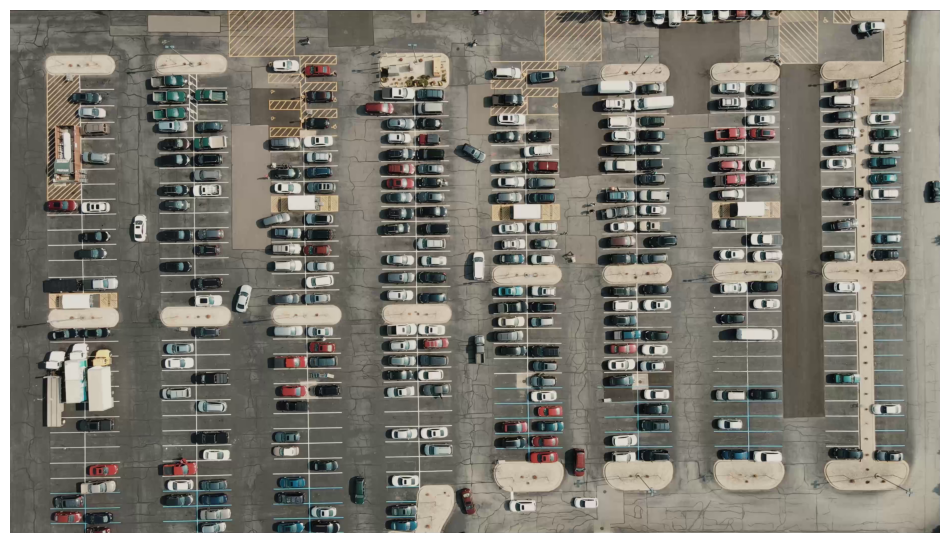

In [ ]:
generator = sv.get_video_frames_generator(PATH_VIDEO)

frame = next(generator)

sv.plot_image(frame)

Existem diversos carros em uma ampla visão do estacionamento, o que pode gerar certa dificuldade na detecção. No entanto, a qualidade da imagem é boa, o que pode facilitar essa detecção.

100%|██████████| 49.7M/49.7M [00:00<00:00, 66.6MB/s]

0: 736x1280 13 cell phones, 2 sinks, 333.5ms
Speed: 47.5ms preprocess, 333.5ms inference, 35.2ms postprocess per image at shape (1, 3, 736, 1280)


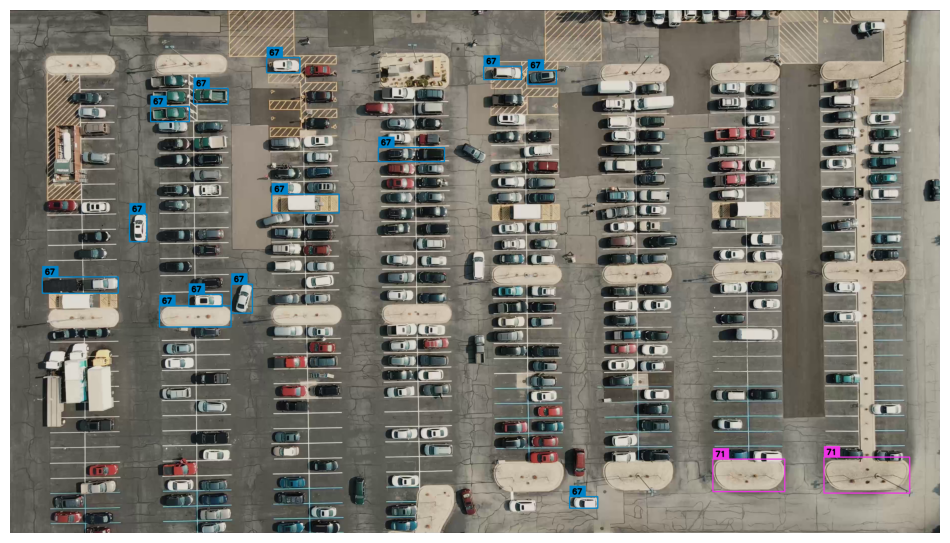

In [ ]:
from ultralytics import YOLO

frame_original = next(generator)

# modelo
model_original = YOLO('yolov8m.pt')

# detecções
results = model_original(frame_original, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# anotações na imagem
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
box_annotator.annotate(scene=frame_original, detections=detections)

sv.plot_image(frame_original)

In [ ]:
print(results.names[67]) # carros estão sendo confundidos com telefones

cell phone


A YOLOv8 medium não está detectando os carros aéreos, está os confundindo com telefones, dessa forma irei treinar ela para detecta-los.

---------------

### **Treinamento e avaliação da YOLOv8 medium**

O dataset será treinado através de um conjunto de dados de detecção de UAV (Veículos Aéreos Não Tripulados) chamado "UAV Car Detection Image Dataset", em uma versão reforçada por mim, disponível e rotulado através do Roboflow. As imagens adicionadas ao dataset foram frames extraídos do próprio vídeo a ser utilizado com o auxílio do Roboflow, uma ferramenta para criar e implantar modelos de visão computacional, bem como fornecer suporte altamente eficiente para criar e rotular datasets.

O dataset original contém 237 imagens de treino, 31 de validação e 31 de teste. O reforçado possui 660 de treino e 31 de validação.

Referência original: https://universe.roboflow.com/txt2csv/uav-car-detection-ksrly

Referência ao dataset criado: https://universe.roboflow.com/mestrado-bkcka/uav-cars-reforced-dataset

In [ ]:
# download do dataset
!pip install roboflow

clear_output()

!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
rf = Roboflow(api_key="ditnodANO1fmF7nyN9UD")
project = rf.workspace("mestrado-bkcka").project("uav-cars-reforced-dataset")
dataset = project.version(2).download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.172, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to UAV-Cars---reforced-dataset-2 in yolov8:: 100%|██████████| 1391/1391 [00:00<00:00, 2081.03it/s]


In [ ]:
%cd {HOME}

/content


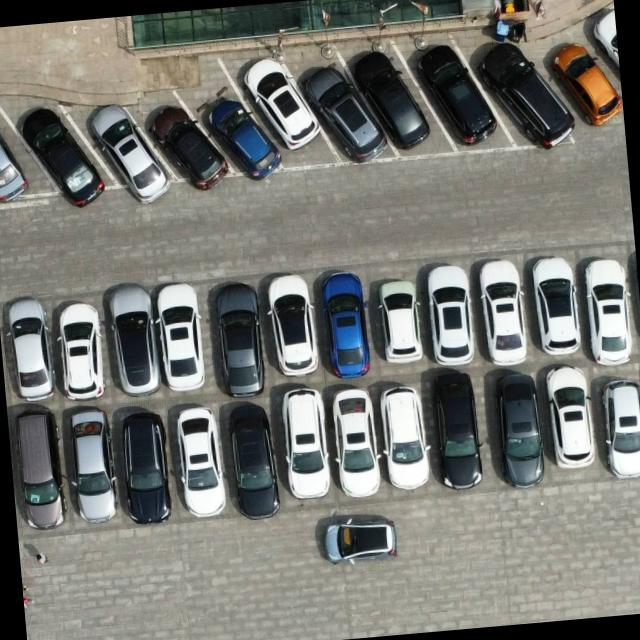

In [ ]:
# imagem dataset
Image(filename=r'/content/datasets/UAV-Cars---reforced-dataset-2/train/images/2-14-_1649859744_jpg.rf.5661a5a0c33501cd62d62b0df1f2f6de.jpg', width=300)

Para treinamento, o arquivo "data.yaml" necessida dos caminhos dos dados de treino, teste e validação.

In [ ]:
# validando o modelo original antes do treinamento
model_original = YOLO("yolov8s.pt")

metrics_original = model_original.val(
    data="/content/datasets/UAV-Cars---reforced-dataset-2/data.yaml",
    imgsz=640
)

print(f'mAP 50: {metrics_original.box.map50:.2%}\nmAP 75: {metrics_original.box.map75:.2%}')

100%|██████████| 21.5M/21.5M [00:00<00:00, 78.1MB/s]
Ultralytics YOLOv8.0.172 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients
100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]
val: Scanning /content/datasets/UAV-Cars---reforced-dataset-2/valid/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 857.01it/s]
val: New cache created: /content/datasets/UAV-Cars---reforced-dataset-2/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]
                   all         31        484     0.0677     0.0372     0.0355     0.0241
                person         31        484     0.0677     0.0372     0.0355     0.0241
Speed: 9.2ms preprocess, 23.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val2


mAP 50: 3.55%
mAP 75: 2.73%


Em uma validação da YOLOv8 realizada com o dataset que será treinado, pode-se ver que o modelo pré-treinado não está detectando praticamente nenhum carro, apresentando métricas de avaliação com péssimos desempenhos.

In [ ]:
# # treinamentod do modelo
# %cd {HOME}
# model = YOLO('yolov8s.pt')

# results = model.train(
#     data="/content/datasets/UAV-Cars---reforced-dataset-2/data.yaml",
#     epochs=60,
#     val=True,
#     save=True,
#     cache='disk',
#     pretrained=True,
#     resume=False, # caso queira continuar o trieno redefina para True
#     project="/content/drive/MyDrive/Colab/treinamento_yolov8m_cars", # caminho para pasta onde salvará os arquivos
#     name="estacionamento_5s",
#     device=0, # cuda device=0
#     patience=10, # número de epochs para parada antecipada
#     seed=42, # sementes aleatório
#     imgsz=640 # tamanho da imagem de input
# )

In [ ]:
# validando o modelo treinado
model_trained = YOLO(r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt")

metrics_trained = model_trained.val(
    data="/content/datasets/UAV-Cars---reforced-dataset-2/data.yaml",
    imgsz=640
)  # no arguments needed, dataset and settings remembered

print(f'mAP 50: {metrics_trained.box.map50:.2%}\nmAP 75: {metrics_trained.box.map75:.2%}')

Ultralytics YOLOv8.0.172 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
val: Scanning /content/datasets/UAV-Cars---reforced-dataset-2/valid/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
                   all         31        484      0.998      0.992      0.995      0.843
Speed: 5.8ms preprocess, 10.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/val3


mAP 50: 99.50%
mAP 75: 98.93%



0: 736x1280 276 cars, 230.4ms
Speed: 22.9ms preprocess, 230.4ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


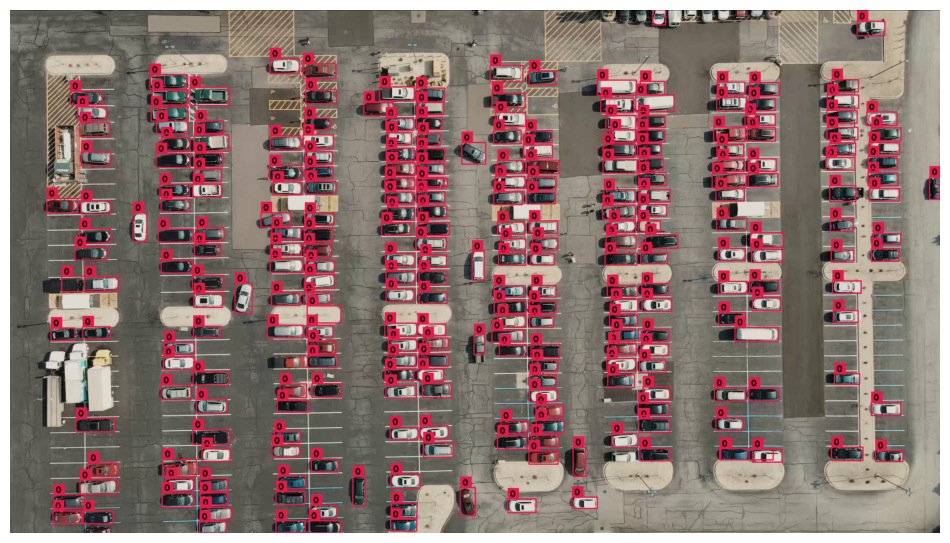

In [ ]:
frame_train = next(generator)

# modelo
#frame_train = cv2.resize(frame_train, (frame_train.shape[1] // 2, frame_train.shape[0] // 2))
model_trained = YOLO(r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt")

# detecções
results = model_trained(frame_train, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[(detections.class_id == 0)]

# anotações na imagem
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
box_annotator.annotate(scene=frame_train, detections=detections)

sv.plot_image(frame_train)

A evolução do modelo é bastante evidente. Agora, ele demonstra uma precisão significativamente maior na detecção de veículos em comparação ao seu estado anterior, apresentando métricas de avaliação excepcionalmente altas.

-------------------------------

## **Redimensionamento do vídeo**

Como já mencionado, o vídeo possui uma resolução alta, o que pode resultar em maior consumo de armazenamento e em processamentos mais lentos, demandando mais capacidade computacional. Por isso, optarei por uma resolução de 1980 pixels de altura e 1920 pixels de largura, o que reduzirá o tamanho, mas sem comprometer significativamente a qualidade.

A interpolação utilizada para o redimensionamento será a cúbica, que resulta em uma imagem de melhor qualidade visual, preservação de detalhes e com menos aliasing.


0: 736x1280 277 cars, 30.2ms
Speed: 3.8ms preprocess, 30.2ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


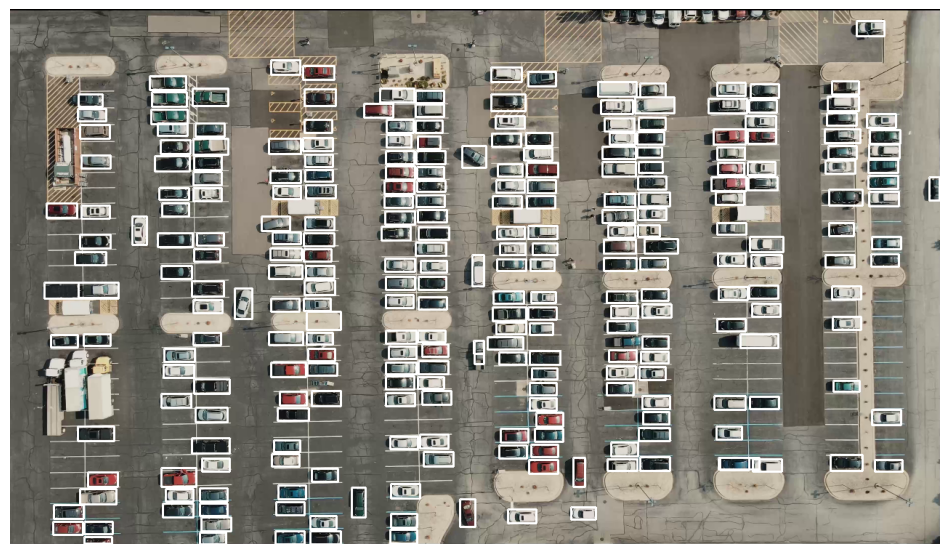

In [ ]:
# parâmetros de interlopalação
width = 1280
height = 736
fps = 10

frame = next(generator) # é necessário sempre chamar um novo frame devido as alterações feitas neles ter caráter destrutivo
frame = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC) # resize

# modelo
model_trained = YOLO(r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt")

# detecções
results = model_trained(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[(detections.class_id == 0)]

# anotações na imagem
box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=0, text_scale=0, text_padding=0, color=sv.Color.white())
box_annotator.annotate(scene=frame, detections=detections)

sv.plot_image(frame)

As detecções se mantiveram com qualidade, só foi necessário fazer alguns ajustes no tamanho das box.

-------------------------------

## **Extração das coordenadas das vagas**

A extração será feita a partir de um frame do vídeo utilizando a ferramenta PolygonZone do Roboflow, que permite extrair uma lista de arrays numpy de coordenadas condizentes com o tamanho do vídeo.

Além da extração das próprias coordenadas, todas as coordenadas relacionadas às máscaras, que são usadas para delimitar a detecção ou filtrar vagas específicas, como as reservadas para pessoas com deficiência (PcD), também serão extraídas com a ajuda do PolygonZone.

In [ ]:
# salvando primeiro frame para extrair as coordenadas das vagas posteriormente
width = 1280
height = 736
fps = 10

frame = next(generator)
frame = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC) # resize

# Save the frame as an image
cv2.imwrite("first_frame.png", frame)

altura, largura, canais = cv2.imread('/content/first_frame.png').shape
print(altura, largura, canais) # reshape realizado

736 1280 3


In [ ]:
# @title Lista de coordenadas das vagas
import numpy as np

vagas_lines = [
np.array([
[72, 275],[72, 275]
]),np.array([
[72, 299],[72, 299]
]),np.array([
[72, 319],[72, 319]
]),np.array([
[68, 343],[68, 343]
]),np.array([
[72, 363],[72, 363]
]),np.array([
[72, 387],[72, 387]
]),np.array([
[72, 459],[72, 459]
]),np.array([
[76, 603],[76, 603]
]),np.array([
[76, 627],[76, 627]
]),np.array([
[76, 647],[76, 647]
]),np.array([
[76, 667],[76, 667]
]),np.array([
[76, 691],[76, 691]
]),np.array([
[72, 715],[72, 715]
]),np.array([
[72, 731],[72, 731]
]),np.array([
[112, 99],[112, 99]
]),np.array([
[112, 123],[112, 123]
]),np.array([
[112, 143],[112, 143]
]),np.array([
[112, 167],[112, 167]
]),np.array([
[112, 191],[112, 191]
]),np.array([
[112, 215],[112, 215]
]),np.array([
[112, 235],[112, 235]
]),np.array([
[112, 255],[112, 255]
]),np.array([
[112, 275],[112, 275]
]),np.array([
[112, 299],[112, 299]
]),np.array([
[112, 319],[112, 319]
]),np.array([
[112, 339],[112, 339]
]),np.array([
[116, 359],[116, 359]
]),np.array([
[119, 387],[119, 387]
]),np.array([
[119, 455],[119, 455]
]),np.array([
[123, 587],[123, 587]
]),np.array([
[123, 607],[123, 607]
]),np.array([
[123, 627],[123, 627]
]),np.array([
[123, 647],[123, 647]
]),np.array([
[123, 671],[123, 671]
]),np.array([
[123, 691],[123, 691]
]),np.array([
[119, 711],[119, 711]
]),np.array([
[119, 731],[119, 731]
]),np.array([
[223, 103],[223, 103]
]),np.array([
[223, 123],[223, 123]
]),np.array([
[219, 147],[219, 147]
]),np.array([
[219, 167],[219, 167]
]),np.array([
[223, 191],[223, 191]
]),np.array([
[223, 215],[223, 215]
]),np.array([
[223, 235],[223, 235]
]),np.array([
[223, 255],[223, 255]
]),np.array([
[223, 275],[223, 275]
]),np.array([
[223, 295],[223, 295]
]),np.array([
[223, 319],[223, 319]
]),np.array([
[223, 339],[223, 339]
]),np.array([
[223, 363],[223, 363]
]),np.array([
[223, 383],[223, 383]
]),np.array([
[223, 407],[223, 407]
]),np.array([
[227, 455],[227, 455]
]),np.array([
[227, 475],[227, 475]
]),np.array([
[227, 499],[227, 499]
]),np.array([
[227, 515],[227, 515]
]),np.array([
[227, 539],[227, 539]
]),np.array([
[227, 559],[227, 559]
]),np.array([
[227, 579],[227, 579]
]),np.array([
[227, 603],[227, 603]
]),np.array([
[227, 623],[227, 623]
]),np.array([
[227, 647],[227, 647]
]),np.array([
[227, 671],[227, 671]
]),np.array([
[227, 691],[227, 691]
]),np.array([
[227, 707],[227, 707]
]),np.array([
[227, 731],[227, 731]
]),np.array([
[279, 99],[279, 99]
]),np.array([
[279, 123],[279, 123]
]),np.array([
[275, 143],[275, 143]
]),np.array([
[275, 171],[275, 167]
]),np.array([
[275, 191],[275, 191]
]),np.array([
[275, 211],[275, 211]
]),np.array([
[275, 235],[275, 235]
]),np.array([
[275, 255],[275, 255]
]),np.array([
[271, 275],[271, 275]
]),np.array([
[271, 299],[271, 299]
]),np.array([
[271, 319],[271, 319]
]),np.array([
[275, 339],[275, 339]
]),np.array([
[271, 363],[271, 363]
]),np.array([
[271, 383],[271, 383]
]),np.array([
[275, 411],[275, 411]
]),np.array([
[275, 455],[275, 455]
]),np.array([
[275, 475],[275, 475]
]),np.array([
[271, 495],[271, 495]
]),np.array([
[275, 519],[275, 519]
]),np.array([
[275, 539],[275, 539]
]),np.array([
[275, 559],[275, 559]
]),np.array([
[275, 579],[275, 579]
]),np.array([
[275, 603],[275, 603]
]),np.array([
[275, 627],[275, 627]
]),np.array([
[275, 643],[275, 643]
]),np.array([
[275, 667],[275, 667]
]),np.array([
[279, 683],[279, 683]
]),np.array([
[279, 707],[279, 707]
]),np.array([
[279, 727],[279, 727]
]),np.array([
[371, 79],[371, 79]
]),np.array([
[371, 115],[371, 115]
]),np.array([
[375, 155],[375, 155]
]),np.array([
[375, 191],[375, 191]
]),np.array([
[379, 211],[379, 211]
]),np.array([
[379, 231],[379, 231]
]),np.array([
[383, 251],[383, 251]
]),np.array([
[379, 295],[379, 295]
]),np.array([
[379, 315],[379, 315]
]),np.array([
[379, 339],[379, 339]
]),np.array([
[379, 359],[379, 359]
]),np.array([
[379, 383],[379, 383]
]),np.array([
[379, 407],[379, 407]
]),np.array([
[379, 451],[379, 451]
]),np.array([
[383, 475],[383, 475]
]),np.array([
[379, 495],[379, 495]
]),np.array([
[383, 515],[383, 515]
]),np.array([
[383, 539],[383, 539]
]),np.array([
[383, 559],[383, 559]
]),np.array([
[383, 579],[383, 579]
]),np.array([
[383, 603],[383, 603]
]),np.array([
[383, 623],[383, 623]
]),np.array([
[383, 639],[383, 639]
]),np.array([
[383, 663],[383, 663]
]),np.array([
[383, 683],[383, 683]
]),np.array([
[383, 707],[383, 707]
]),np.array([
[383, 731],[383, 731]
]),np.array([
[427, 87],[427, 87]
]),np.array([
[427, 123],[427, 123]
]),np.array([
[427, 163],[427, 163]
]),np.array([
[427, 187],[427, 187]
]),np.array([
[427, 211],[427, 211]
]),np.array([
[427, 231],[427, 231]
]),np.array([
[427, 251],[427, 251]
]),np.array([
[427, 295],[427, 295]
]),np.array([
[427, 315],[427, 315]
]),np.array([
[427, 339],[427, 339]
]),np.array([
[427, 363],[427, 363]
]),np.array([
[427, 383],[427, 383]
]),np.array([
[427, 403],[427, 403]
]),np.array([
[427, 455],[427, 455]
]),np.array([
[427, 475],[427, 475]
]),np.array([
[427, 495],[427, 495]
]),np.array([
[431, 515]
]),np.array([
[431, 535]
]),np.array([
[431, 555]
]),np.array([
[431, 579]
]),np.array([
[431, 599]
]),np.array([
[431, 619]
]),np.array([
[431, 643]
]),np.array([
[431, 663]
]),np.array([
[431, 683]
]),np.array([
[431, 707]
]),np.array([
[431, 727]
]),np.array([
[533, 119]
]),np.array([
[533, 139]
]),np.array([
[533, 159]
]),np.array([
[533, 183]
]),np.array([
[533, 203]
]),np.array([
[533, 223]
]),np.array([
[533, 247]
]),np.array([
[533, 267]
]),np.array([
[533, 287]
]),np.array([
[533, 307]
]),np.array([
[533, 331]
]),np.array([
[533, 355]
]),np.array([
[533, 375]
]),np.array([
[533, 403]
]),np.array([
[537, 451]
]),np.array([
[537, 471]
]),np.array([
[537, 491]
]),np.array([
[537, 515]
]),np.array([
[537, 535]
]),np.array([
[537, 555]
]),np.array([
[533, 575]
]),np.array([
[537, 595]
]),np.array([
[537, 619]
]),np.array([
[533, 639]
]),np.array([
[541, 663]
]),np.array([
[537, 683]
]),np.array([
[537, 703]
]),np.array([
[581, 119]
]),np.array([
[577, 139]
]),np.array([
[577, 159]
]),np.array([
[577, 183]
]),np.array([
[577, 203]
]),np.array([
[577, 223]
]),np.array([
[577, 243]
]),np.array([
[577, 263]
]),np.array([
[577, 287]
]),np.array([
[577, 311]
]),np.array([
[577, 331]
]),np.array([
[577, 355]
]),np.array([
[577, 375]
]),np.array([
[581, 403]
]),np.array([
[581, 451]
]),np.array([
[581, 471]
]),np.array([
[585, 491]
]),np.array([
[585, 511]
]),np.array([
[585, 535]
]),np.array([
[585, 555]
]),np.array([
[585, 575]
]),np.array([
[585, 595]
]),np.array([
[585, 619]
]),np.array([
[581, 639]
]),np.array([
[581, 659]
]),np.array([
[681, 87]
]),np.array([
[681, 127]
]),np.array([
[681, 155]
]),np.array([
[681, 179]
]),np.array([
[677, 199]
]),np.array([
[681, 223]
]),np.array([
[681, 243]
]),np.array([
[681, 263]
]),np.array([
[685, 307]
]),np.array([
[685, 327]
]),np.array([
[685, 351]
]),np.array([
[685, 395]
]),np.array([
[685, 419]
]),np.array([
[685, 439]
]),np.array([
[685, 459]
]),np.array([
[685, 479]
]),np.array([
[685, 499]
]),np.array([
[685, 523]
]),np.array([
[685, 543]
]),np.array([
[685, 567]
]),np.array([
[689, 587]
]),np.array([
[689, 607]
]),np.array([
[689, 627]
]),np.array([
[733, 95]
]),np.array([
[733, 135]
]),np.array([
[729, 159]
]),np.array([
[729, 179]
]),np.array([
[729, 199]
]),np.array([
[729, 223]
]),np.array([
[729, 243]
]),np.array([
[729, 267]
]),np.array([
[733, 307]
]),np.array([
[733, 327]
]),np.array([
[733, 351]
]),np.array([
[729, 395]
]),np.array([
[733, 419]
]),np.array([
[733, 439]
]),np.array([
[733, 459]
]),np.array([
[729, 479]
]),np.array([
[733, 503]
]),np.array([
[733, 523]
]),np.array([
[733, 543]
]),np.array([
[737, 567]
]),np.array([
[737, 587]
]),np.array([
[737, 607]
]),np.array([
[737, 627]
]),np.array([
[837, 111]
]),np.array([
[837, 135]
]),np.array([
[837, 159]
]),np.array([
[837, 179]
]),np.array([
[837, 199]
]),np.array([
[837, 219]
]),np.array([
[837, 243]
]),np.array([
[837, 263]
]),np.array([
[837, 283]
]),np.array([
[837, 303]
]),np.array([
[837, 327]
]),np.array([
[841, 351]
]),np.array([
[841, 395]
]),np.array([
[841, 415]
]),np.array([
[841, 439]
]),np.array([
[841, 459]
]),np.array([
[841, 475]
]),np.array([
[841, 499]
]),np.array([
[841, 523]
]),np.array([
[837, 543]
]),np.array([
[841, 563]
]),np.array([
[841, 587]
]),np.array([
[841, 607]
]),np.array([
[841, 627]
]),np.array([
[881, 111]
]),np.array([
[881, 135]
]),np.array([
[881, 155]
]),np.array([
[881, 175]
]),np.array([
[881, 199]
]),np.array([
[881, 219]
]),np.array([
[881, 239]
]),np.array([
[881, 263]
]),np.array([
[881, 283]
]),np.array([
[881, 303]
]),np.array([
[881, 327]
]),np.array([
[881, 347]
]),np.array([
[885, 395]
]),np.array([
[885, 415]
]),np.array([
[885, 435]
]),np.array([
[885, 459]
]),np.array([
[885, 479]
]),np.array([
[885, 499]
]),np.array([
[885, 523]
]),np.array([
[885, 539]
]),np.array([
[885, 563]
]),np.array([
[885, 587]
]),np.array([
[881, 603]
]),np.array([
[881, 627]
]),np.array([
[989, 111]
]),np.array([
[989, 135]
]),np.array([
[989, 155]
]),np.array([
[989, 175]
]),np.array([
[989, 195]
]),np.array([
[989, 219]
]),np.array([
[989, 239]
]),np.array([
[989, 263]
]),np.array([
[989, 303]
]),np.array([
[985, 327]
]),np.array([
[989, 343]
]),np.array([
[989, 391]
]),np.array([
[989, 415]
]),np.array([
[989, 435]
]),np.array([
[985, 455]
]),np.array([
[989, 475]
]),np.array([
[989, 499]
]),np.array([
[989, 519]
]),np.array([
[989, 539]
]),np.array([
[989, 559]
]),np.array([
[989, 583]
]),np.array([
[989, 603]
]),np.array([
[993, 623]
]),np.array([
[1033, 111]
]),np.array([
[1033, 135]
]),np.array([
[1033, 155]
]),np.array([
[1029, 175]
]),np.array([
[1033, 199]
]),np.array([
[1033, 219]
]),np.array([
[1033, 239]
]),np.array([
[1029, 263]
]),np.array([
[1033, 303]
]),np.array([
[1033, 327]
]),np.array([
[1033, 347]
]),np.array([
[1033, 387]
]),np.array([
[1033, 411]
]),np.array([
[1033, 435]
]),np.array([
[1037, 455]
]),np.array([
[1033, 475]
]),np.array([
[1033, 499]
]),np.array([
[1033, 519]
]),np.array([
[1033, 539]
]),np.array([
[1033, 559]
]),np.array([
[1033, 583]
]),np.array([
[1033, 603]
]),np.array([
[1033, 627]
]),np.array([
[1137, 107]
]),np.array([
[1137, 131]
]),np.array([
[1141, 151]
]),np.array([
[1145, 175]
]),np.array([
[1145, 195]
]),np.array([
[1145, 215]
]),np.array([
[1145, 239]
]),np.array([
[1145, 259]
]),np.array([
[1145, 283]
]),np.array([
[1145, 303]
]),np.array([
[1145, 323]
]),np.array([
[1145, 343]
]),np.array([
[1149, 391]
]),np.array([
[1145, 411]
]),np.array([
[1145, 435]
]),np.array([
[1145, 455]
]),np.array([
[1145, 475]
]),np.array([
[1149, 499]
]),np.array([
[1149, 519]
]),np.array([
[1149, 539]
]),np.array([
[1149, 559]
]),np.array([
[1149, 583]
]),np.array([
[1149, 603]
]),np.array([
[1149, 627]
]),np.array([
[1201, 135]
]),np.array([
[1201, 155]
]),np.array([
[1201, 175]
]),np.array([
[1201, 195]
]),np.array([
[1201, 215]
]),np.array([
[1201, 239]
]),np.array([
[1201, 259]
]),np.array([
[1201, 279]
]),np.array([
[1201, 303]
]),np.array([
[1201, 323]
]),np.array([
[1201, 343]
]),np.array([
[1201, 391]
]),np.array([
[1201, 411]
]),np.array([
[1201, 435]
]),np.array([
[1201, 455]
]),np.array([
[1201, 475]
]),np.array([
[1201, 495]
]),np.array([
[1201, 519]
]),np.array([
[1201, 539]
]),np.array([
[1205, 563]
]),np.array([
[1205, 583]
]),np.array([
[1205, 603]
]),np.array([
[1205, 627]
])
]

Cada vaga possui 1 pontos de coordenada para cobrir o espaço da vaga sem invadir o espaço de outra vaga, como poderia ocorrer em retangulos, principalmente devido a sua resolução.  A imagem a seguir ilustra o descrito.



In [ ]:
# função que retira o segundo ponto das coordenadas das vagas que foram colocados acidentalmente
def clear_lista_vagas(lista_de_arrays):
    # Crie uma lista para armazenar os arrays resultantes
    arrays_resultantes = []

    # Itere sobre a lista de arrays
    for arr in lista_de_arrays:
        # Verifique se o array possui um item de índice 1
        if len(arr) > 1:
            # Se o array tiver mais de um item, elimine o item de índice 1
            arr = arr[[0]]

        # Adicione o novo array ou o array original à lista de resultados
        arrays_resultantes.append(arr)

    return arrays_resultantes

vagas_ordenadas = clear_lista_vagas(vagas_lines)

In [ ]:
# máscara para diferenciar vagas pcd
mask_pcd = [np.array([[348, 63],[456, 175]]),np.array([[656, 67],[764, 147]])]

As vagas PcD serão diferenciadas através de coloração, bem como na contagem de vagas disponíveis. Para isso, será utilizado a máscara de polígono para filtragem.

In [ ]:
# lista da mascara limitadora de região de detecção
polygon_mask = np.array([[41, 54],[49, 734],[577, 734],[609, 662],[1249, 662],[1233, 54]])

**Primeiro escopo do projeto.**



0: 736x1280 279 cars, 35.0ms
Speed: 3.9ms preprocess, 35.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


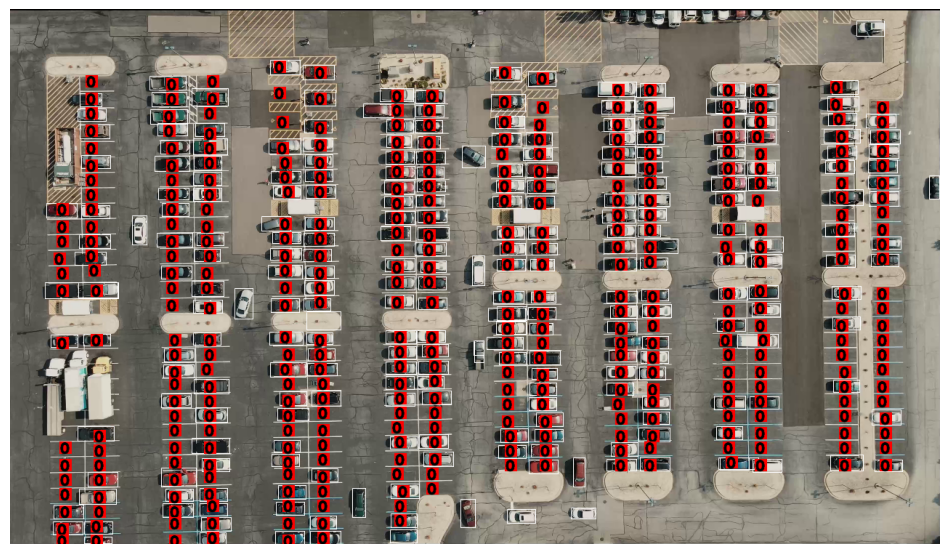

In [ ]:
width = 1280
height = 736
fps = 10

frame_train = next(generator)
frame_train = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC) # resize

# modelo
model_trained = YOLO(r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt")

# detecções
results = model_trained(frame_train, imgsz=1280)[0] # fornece as boxes do predito, nome do objeto predito (carro) e outras informações
detections = sv.Detections.from_ultralytics(results) # fornece as coordenadas xyxy das bounding boxes
detections = detections[(detections.class_id == 0)] # filtra somenta a carros

# anotações na imagem
video_info = sv.VideoInfo.from_video_path(video_path=PATH_VIDEO) # extrai informações dos vídeos
zones = [       # lista de objetos das coordenadas das vagas para anotar na imagem
    sv.PolygonZone(
        polygon=vaga,
        frame_resolution_wh=video_info.resolution_wh
    )
    for vaga
    in vagas_ordenadas
]

box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=0, text_scale=0, text_padding=0, color=sv.Color.white()) # especificações das bounding boxes dos carros

zones_annotator = [ # especificações das zonas das vagas
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=sv.Color.red(),
        text_padding=1,
        thickness=0,
        text_thickness=2,
        text_scale=0.6,
    )
    for zone
    in zones
]
# anotações das bounding boxes e vagas
box_annotator.annotate(scene=frame_train, detections=detections)
for zone_annotator in zones_annotator:
    zone_annotator.annotate(scene=frame_train, label='0')

sv.plot_image(frame_train)

Na imagem acima pode-se observar o primeiro escopo do projeto. É possível ver as anotações tanto dos carros quanto das vagas na imagem, mas sem as diferentes distinções de vagas e sua disponibilidade.

--------------------

## **Condicionamento de vaga ocupada ou disponível e distinção entre vagas**

A lógica que deverá ser seguida para distinguir se uma vaga está ocupada ou não é a seguinte:

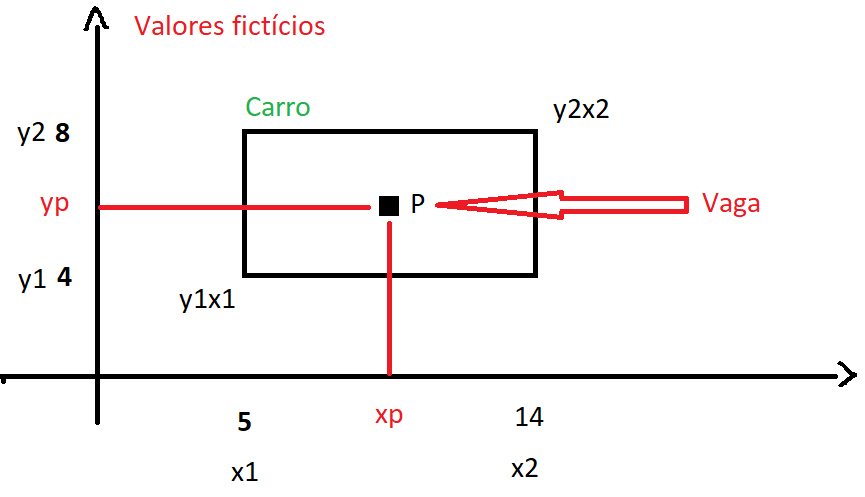

O ponto P representa a vaga, se um ponto P estiver dentro de uma bounding box, que representa um carro, a vaga estará ocupada. Como existem dois "pontos P" (uma reta) para cada vaga, se qualquer um dos pontos estiverem dentro de uma bounding box de um carro, a vaga será considerada ocupada.

Condição para vaga ocupada: (y2 > yp > y1) and (x2 > xp > x1)

In [ ]:
print(detections.xyxy[0]) # formato [x1, y1, x2, y2] lembrando que condição para vaga ocupada: (x2 > xp > x1) and (y2 > yp > y1)
print(vagas_ordenadas[0]) # xp1, yp1, xp2, yp2

[     2796.9      1788.7      3082.8      1917.7]
[[ 72 275]]


A seguir, ocorre todo o processamento realizado para um frame, desde a detecção de carros até a delimitação do campo de detecção, verificando se a vaga está ocupada ou não, e identificando se é uma vaga regular ou para pessoas com deficiência (PcD). Além disso, foi adicionado um contador de vagas disponíveis, tanto para vagas regulares como para PcD, no formato "vagas disponíveis/vagas totais".


0: 736x1280 279 cars, 30.1ms
Speed: 3.7ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


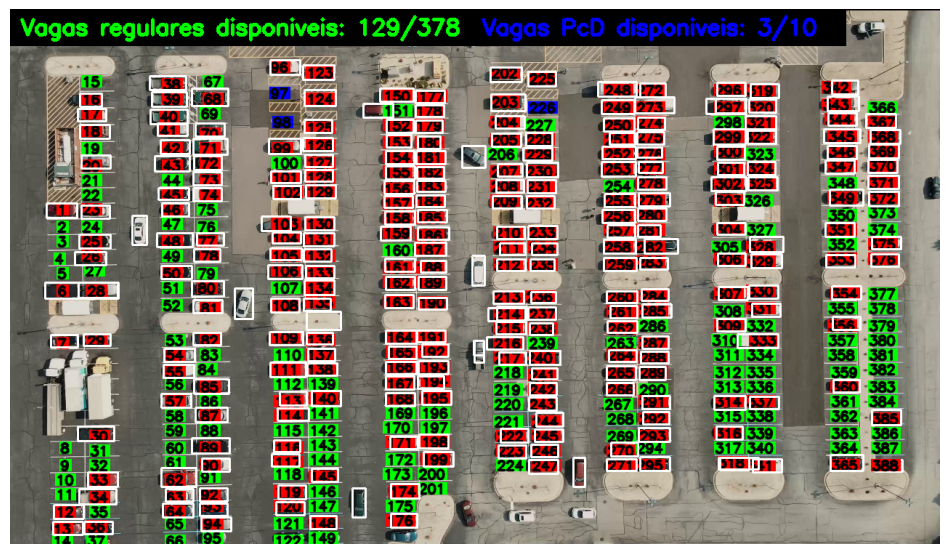

In [ ]:
width = 1280
height = 736
fps = 10

frame_train = next(generator)
frame_train = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC) # resize

# modelo de detecção
model_trained = YOLO(r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt")

# detecções
results = model_trained(frame_train, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

zone_mask = sv.PolygonZone(polygon=polygon_mask, frame_resolution_wh=(width, height))
mask = zone_mask.trigger(detections=detections)

# unpacking das coordenadas na imagem que identificam as vagas PcD
pcd_1, pcd_2 = mask_pcd
xa_pcd_1, ya_pcd_1, xc_pcd_1, yc_pcd_1 = pcd_1.flatten()
xa_pcd_2, ya_pcd_2, xc_pcd_2, yc_pcd_2 = pcd_2.flatten()

detections = detections[(detections.class_id == 0) & mask]

# totais de vagas
total_vagas_pcd = 10
total_vagas_regulares = len(vagas_ordenadas) - total_vagas_pcd

# contadores
vagas_disponiveis_regulares = 0
vagas_disponiveis_pcd = 0
n_vaga = 0

# loop pelas vagas
for vaga in vagas_ordenadas:
    n_vaga += 1
    xp1, yp1 = vaga.flatten().astype(float)
    vaga_ocupada = False

    # verifique se a vaga está ocupada por qualquer carro
    for box in detections.xyxy:
        x1, y1, x2, y2 = box
        if (y2 > yp1 > y1) and (x2 > xp1 > x1): # se a box do carro estiver ao redor do ponto de coordenada da vaga, a vaga está ocupada
            vaga_ocupada = True
            break  # se a vaga estiver ocupada, não há necessidade de verificar com mais carros

    # preparar e aplicar anotações com base no status da vaga
    zone_vaga = sv.PolygonZone(polygon=vaga, frame_resolution_wh=(width, height))
    box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=0, text_scale=0, text_padding=0, color=sv.Color.white())

    if vaga_ocupada: # se true, pinte de vermelho
        zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.red(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.6)
    else: # se false, pinte de verde ou azul de acordo com a segunda condição
        if ((xc_pcd_1 > xp1 > xa_pcd_1) and (yc_pcd_1 > yp1 > ya_pcd_1)) or ((xc_pcd_2 > xp1 > xa_pcd_2) and (yc_pcd_2 > yp1 > ya_pcd_2)):
          vagas_disponiveis_pcd += 1
          zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.blue(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.6)
        else:
          vagas_disponiveis_regulares += 1
          zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.green(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.6)

    # Preparar anotações
    box_annotator.annotate(scene=frame_train, detections=detections) # anota as bounding box dos carros
    zone_vaga_annotator.annotate(scene=frame_train, label=f'{n_vaga}') # anota a vaga

# escrevendo o número de vagas disponíveis no canto superior esquerdo
texto_regulares = f'Vagas regulares disponiveis: {vagas_disponiveis_regulares}/{total_vagas_regulares}'
texto_pcd = f'Vagas PcD disponiveis: {vagas_disponiveis_pcd}/{total_vagas_pcd}'

cv2.rectangle(frame_train, (0, 0), (1150, 50), (0, 0, 0), thickness=-1) # gerando um retangulo de fundo dos textos para melhorar a visualização

cv2.putText(frame_train, texto_regulares, (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3) # colocando os textos
cv2.putText(frame_train, texto_pcd, (650, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3) # colocando os textos

# visualizar a imagem resultante
sv.plot_image(frame_train)

O projeto está quase finalizado. Todas as etapas de processamento de frames foram concluídas com sucesso. Os carros estão sendo detectados, as vagas estão sendo classificadas como ocupadas ou disponíveis, e são diferenciadas entre vagas regulares e vagas para pessoas com deficiência (PcD). Além disso, um contador da quantidade de vagas disponíveis é exibido no canto superior esquerdo.

---------------------

## **Processamento do vídeo e versão final do projeto**

Em vez de processar o vídeo inteiro na memória, irei processá-lo frame a frame utilizando a função "process_video" de supervisão. Uma função "callback" será criada para processar os frames. Essa função, será basicamente o processamento de frame criado na etapa anterior.

O modelo de função a ser seguido, como recomendado na documentação é o seguinte:

>>> def callback(scene: np.ndarray, index: int) -> np.ndarray:
...

>>> process_video(
...     source_path='...',
...     target_path='...',
...     callback=callback
... )


Nesta etapa, todas as variáveis estáticas, que permanecem inalteradas ao longo do processo, não serão incluídas dentro da função nem dos loops dentro das funções, com o objetivo de otimizar ao máximo o tempo de processamento.

-----------------

### **Processamento 1:** loop em loop

Esse é o processamento final obtido a partir da lógica seguida durante todo o projeto, um loop em loop das vagas nos carros.

In [ ]:
import time

In [ ]:
# caminho para o vídeo
PATH_VIDEO = "/content/drive/MyDrive/Colab/video_estacionamento.mp4"

# caminho de armazenamento do vídeo processado junto ao seu nome
nome_video = "deteccao_vagas_conf02_9.mp4"
PATH_armazenamento_video = f"/content/drive/MyDrive/Colab/{nome_video}"

# modelo
PATH_modelo = r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt"

# Abra o vídeo de entrada
input_video = cv2.VideoCapture(PATH_VIDEO)

# Defina as configurações do vídeo de saída
output_path = r'/content/drive/MyDrive/Colab/output_deteccaovagas.mp4'
width = 1280
height = 736
fps = 10

# Crie o objeto VideoWriter para o vídeo de saída
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# modelo
model = YOLO(PATH_modelo)

# máscara da zona de detecção de carros
zone_mask = sv.PolygonZone(polygon=polygon_mask, frame_resolution_wh=(width, height))

# unpacking das coordenadas na imagem que identificam as vagas PcD
pcd_1, pcd_2 = mask_pcd
xa_pcd_1, ya_pcd_1, xc_pcd_1, yc_pcd_1 = pcd_1.flatten()
xa_pcd_2, ya_pcd_2, xc_pcd_2, yc_pcd_2 = pcd_2.flatten()

# número total de vagas
total_vagas_pcd = 10
total_vagas_regulares = len(vagas_ordenadas) - total_vagas_pcd

frame_count = 0 # contador de frames
frame_process = 0 # frames processados
start_time = time.time() # tempo de início do processamento

# loop pelos frames do vídeo de entrada
while True:
    ret, frame = input_video.read()

    if not ret:
        break  # Fim do vídeo

    frame_count += 1

    if frame_count % 3 == 0: # processe apenas frames de resto 3, ou seja, cortando 30 fps para 10 fps

        frame_process += 1 # contador de frames processados

        frame = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC) # redução de dimensão

        # detecções
        results = model(frame, imgsz=1280, conf=0.02)[0] # predição
        detections = sv.Detections.from_ultralytics(results)

        # aplicando máscaras e filtros de detecção
        mask = zone_mask.trigger(detections=detections)
        detections = detections[(detections.class_id == 0) & mask]

        # contagens de vagas disponíveis
        vagas_disponiveis_regulares = 0
        vagas_disponiveis_pcd = 0

        # loop pelas vagas
        for n_vaga, vaga in enumerate(vagas_ordenadas):
            n_vaga += 1
            xp1, yp1 = vaga.flatten()
            vaga_ocupada = False

            # loop dentro das bbox dos carros
            for bbox in detections.xyxy:
                x1, y1, x2, y2 = bbox.flatten()
                bbox = (x1, y1, x2, y2)

                if (y2 > yp1 > y1) and (x2 > xp1 > x1): # se a bbox do carro estiver ao redor do ponto de coordenada da vaga, a vaga está ocupada
                    vaga_ocupada = True
                    break  # se a vaga estiver ocupada, não há necessidade de verificar com mais carros

            # preparar e aplicar anotações com base no status da vaga
            zone_vaga = sv.PolygonZone(polygon=vaga, frame_resolution_wh=(width, height))

            if vaga_ocupada: # se true, pinte de vermelho
                zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.red(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)

            else: # se false, pinte de verde ou azul de acordo com a segunda condição
                if ((xc_pcd_1 > xp1 > xa_pcd_1) and (yc_pcd_1 > yp1 > ya_pcd_1)) or ((xc_pcd_2 > xp1 > xa_pcd_2) and (yc_pcd_2 > yp1 > ya_pcd_2)):
                  vagas_disponiveis_pcd += 1
                  zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.blue(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)

                else:
                  vagas_disponiveis_regulares += 1
                  zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.green(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)

            # Preparar anotações
            zone_vaga_annotator.annotate(scene=frame, label=f'{n_vaga}') # anota a vaga

        # texto de número de vagas disponíveis
        texto_regulares = f'Vagas regulares disponiveis: {vagas_disponiveis_regulares}/{total_vagas_regulares}'
        texto_pcd = f'Vagas PcD disponiveis: {vagas_disponiveis_pcd}/{total_vagas_pcd}'

        # gerando um retangulo de fundo dos textos para melhorar a visualização
        cv2.rectangle(frame, (0, 0), (1150, 50), (0, 0, 0), thickness=-1)

        # inserindo texto no canto superior esquerdo
        cv2.putText(frame, texto_regulares, (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3) # colocando os textos
        cv2.putText(frame, texto_pcd, (650, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3) # colocando os textos

        # Escreva o frame processado no vídeo de saída
        output_video.write(frame)

# feche os vídeos
input_video.release()
output_video.release()
cv2.destroyAllWindows()

# calculo de fps médio
end_time = time.time()
elapsed_time = end_time - start_time
fps = frame_process / elapsed_time

clear_output()
print(f'FPS: {fps}')

FPS: 1.239469380502248


### **Processamento 2:** Rtree carro mais próximo

No loop em loop, praticamente para cada vaga é percorrido todas detecções de carros, restringindo se a vaga é ocupada que o loop é rompido pelo break. No entanto, ainda assim se por "azar" o último carro é o que ocupa a vaga, ela ainda percorreria todos carros.

Pensando nesse problema, desenvolvi uma metodologia mais ágil, que através de Rtree, detecta para cada carro (bounding box) a vaga mais próxima. Após isso, verifica se essa vaga está ocupada ou não.

In [ ]:
from rtree import Rtree

# chamada do Rtree
rt = Rtree()

# dicionário de índices e coordenadas de vagas
dict_vagas_totais = {}

# loop para inserir o índice e coordenadas das vagas a Rtree e ao dicionário para consulta
for i, vaga in enumerate(vagas_ordenadas):
  x1, y1 = vaga.flatten()
  rt.insert(i, (x1, y1))
  dict_vagas_totais[i] = (x1, y1, x1, y1)

In [ ]:
# caminho para o vídeo
PATH_VIDEO = "/content/drive/MyDrive/Colab/video_estacionamento.mp4"

# caminho de armazenamento do vídeo processado junto ao seu nome
nome_video = "deteccao_vagas_conf02_9.mp4"
PATH_armazenamento_video = f"/content/drive/MyDrive/Colab/{nome_video}"

# modelo
PATH_modelo = r"/content/drive/MyDrive/Colab/treinamento_yolov8m_cars/estacionamento_v5s/weights/best.pt"

# Abra o vídeo de entrada
input_video = cv2.VideoCapture(PATH_VIDEO)

# Defina as configurações do vídeo de saída
output_path = r'/content/drive/MyDrive/Colab/output_deteccaovagas.mp4'
width = 1280
height = 736
fps = 10

# Crie o objeto VideoWriter para o vídeo de saída
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# modelo
model = YOLO(PATH_modelo)

# máscara da zona de detecção de carros
zone_mask = sv.PolygonZone(polygon=polygon_mask, frame_resolution_wh=(width, height))

# unpacking das coordenadas na imagem que identificam as vagas PcD
pcd_1, pcd_2 = mask_pcd
xa_pcd_1, ya_pcd_1, xc_pcd_1, yc_pcd_1 = pcd_1.flatten()
xa_pcd_2, ya_pcd_2, xc_pcd_2, yc_pcd_2 = pcd_2.flatten()

# número total de vagas
total_vagas_pcd = 10
total_vagas_regulares = len(vagas_ordenadas) - total_vagas_pcd

frame_count = 0 # contador de frames
frame_process = 0 # frames processados
start_time = time.time() # tempo de início do processamento

# loop pelos frames do vídeo de entrada
while True:
    ret, frame = input_video.read()

    if not ret:
        break  # Fim do vídeo

    frame_count += 1

    if frame_count % 3 == 0: # processe apenas frames pares, ou seja, cortando 30 fps para 15
        frame_process += 1
        # redução de dimensão
        frame = cv2.resize(frame, (width, height), fx=0, fy=0, interpolation = cv2.INTER_CUBIC)

        # detecções
        results = model(frame, imgsz=1280, conf=0.02)[0]  # Correção aqui
        detections = sv.Detections.from_ultralytics(results)

        # aplicando máscaras e filtros de detecção
        mask = zone_mask.trigger(detections=detections)
        detections = detections[(detections.class_id == 0) & mask]

        # contagens de vagas disponíveis
        vagas_disponiveis_regulares = 0
        vagas_disponiveis_pcd = 0

        # vagas vistas
        vagas_vistas = []

        # verifique se a vaga está ocupada por qualquer carro
        for box in detections.xyxy:
            x1, y1, x2, y2 = box
            bbox = (x1, y1, x2, y2)
            vaga_ocupada = False

            vaga_near = next(rt.nearest(coordinates=bbox, num_results=1, objects='raw+data'), None)
            i = vaga_near.id
            xp1, yp1, _, _ = vaga_near.bbox

            vagas_vistas.append(i)
            vaga_form = np.array([[xp1, yp1]], dtype=np.int32)

            if (y2 > yp1 > y1) and (x2 > xp1 > x1): # se a box do carro estiver ao redor do ponto de coordenada da vaga, a vaga está ocupada
                vaga_ocupada = True
                # break  # se a vaga estiver ocupada, não há necessidade de verificar com mais carros

            # preparar e aplicar anotações com base no status da vaga
            zone_vaga = sv.PolygonZone(polygon=vaga_form, frame_resolution_wh=(width, height))

            if vaga_ocupada: # se true, pinte de vermelho
                zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.red(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)
            else: # se false, pinte de verde ou azul de acordo com a segunda condição
                if ((xc_pcd_1 > xp1 > xa_pcd_1) and (yc_pcd_1 > yp1 > ya_pcd_1)) or ((xc_pcd_2 > xp1 > xa_pcd_2) and (yc_pcd_2 > yp1 > ya_pcd_2)):
                  vagas_disponiveis_pcd += 1
                  zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.blue(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)
                else:
                  vagas_disponiveis_regulares += 1
                  zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.green(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)

            # Preparar anotações
            zone_vaga_annotator.annotate(scene=frame, label=f'{i+1}') # anota a vaga

        vagas_nao_vistas = list(set(dict_vagas_totais.keys()) - set(vagas_vistas))

        for i in vagas_nao_vistas:

            xp1, yp1, _, _ = dict_vagas_totais[i]
            vaga_form = np.array([[xp1, yp1]], dtype=np.int32)

            zone_vaga = sv.PolygonZone(polygon=vaga_form, frame_resolution_wh=(width, height))

            if ((xc_pcd_1 > xp1 > xa_pcd_1) and (yc_pcd_1 > yp1 > ya_pcd_1)) or ((xc_pcd_2 > xp1 > xa_pcd_2) and (yc_pcd_2 > yp1 > ya_pcd_2)):
              vagas_disponiveis_pcd += 1
              zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.blue(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)
            else:
              vagas_disponiveis_regulares += 1
              zone_vaga_annotator = sv.PolygonZoneAnnotator(zone=zone_vaga, color=sv.Color.green(), text_padding=1, thickness=0, text_thickness=2, text_scale=0.5)

            zone_vaga_annotator.annotate(scene=frame, label=f'{i+1}')

        # escrevendo o número de vagas disponíveis no canto superior esquerdo
        texto_regulares = f'Vagas regulares disponiveis: {vagas_disponiveis_regulares}/{total_vagas_regulares}'
        texto_pcd = f'Vagas PcD disponiveis: {vagas_disponiveis_pcd}/{total_vagas_pcd}'

        cv2.rectangle(frame, (0, 0), (1150, 50), (0, 0, 0), thickness=-1) # gerando um retangulo de fundo dos textos para melhorar a visualização

        cv2.putText(frame, texto_regulares, (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3) # colocando os textos
        cv2.putText(frame, texto_pcd, (650, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3) # colocando os textos

        # Escreva o frame processado no vídeo de saída
        output_video.write(frame)

# Feche os vídeos
input_video.release()
output_video.release()
cv2.destroyAllWindows()

# calculo de fps médio
end_time = time.time()
elapsed_time = end_time - start_time
fps = frame_process / elapsed_time

clear_output()
print(f'FPS: {fps}')

FPS: 2.002493259146649


É possível perceber, através do FPS (quadros por segundo), que, embora seja baixo para ambos os processamentos, o Processamento 2 apresentou um desempenho cerca de 3 vezes maior do que o Processamento 1. Isso foi possível devido à redução significativa de iterações desnecessárias.

No entanto, o Processamento 2 apresenta uma oscilação pronunciada entre as detecções de vaga ocupada e disponível, o que pode criar a sensação de "piscar" no vídeo processado. Isso é oposto ao que ocorre no Processamento 1, que é muito mais estável. Acredito que essa oscilação ocorra devido à "vaga mais próxima" ao carro variar em cada frame processado, fazendo com que o carro pareça ocupar a vaga mais próxima em alguns momentos e não ocupá-la em outros.

## **Conclusão**

O projeto desenvolveu com sucesso uma aplicação da Visão Computacional e Machine Learning para resolver um problema cotidiano que afeta milhões de pessoas em todo o mundo. A busca por vagas de estacionamento costuma ser uma fonte significativa de frustração e desperdício de tempo para os motoristas, e esse projeto demonstra como a tecnologia pode desempenhar um papel fundamental na melhoria dessa experiência.

A utilização do YOLOv8, uma rede neural convolucional de ponta, juntamente com técnicas de detecção de veículos e localização de vagas, oferece uma proposta de solução abrangente e eficaz para identificar a disponibilidade de vagas de estacionamento em tempo real. Além disso, a capacidade de diferenciar entre vagas regulares e vagas para pessoas com deficiência (PcD) e fornecer informações visuais claras aos motoristas é um avanço importante na promoção da inclusão e na melhoria da gestão de estacionamentos.

Os benefícios esperados em uma aplicação deste projeto são amplos, abrangendo desde a redução do estresse dos motoristas até a contribuição para a redução do congestionamento de tráfego e a otimização do uso de espaços de estacionamento. Além disso, a capacidade de contar e exibir a quantidade de vagas disponíveis em tempo real fornece informações valiosas para os usuários, tornando a busca por vagas mais eficiente e conveniente.

Devido ao elevado número de vagas disponíveis, totalizando 388, e à detecção de aproximadamente 300 veículos em cada quadro processado, a tarefa de processamento de vídeo revelou-se computacionalmente intensiva em termos de Taxa de Quadros por Segundo (FPS). Em cenários de processamento em tempo real, os resultados obtidos demonstraram um desempenho que varia de acordo com os métodos utilizados.

No cenário denominado "Processamento 1", observou-se uma taxa de processamento de aproximadamente 1.2 FPS. Já no cenário "Processamento 2", o desempenho melhorou um pouco, atingindo cerca de 3 FPS. Estes números refletem o desafio computacional enfrentado devido à combinação de um grande número de vagas e um alto volume de detecções de veículos em cada quadro do vídeo, tornando essencial considerar otimizações para atender às necessidades específicas de cada aplicação.

Cerca de 2 a 3 FPS não teriam um impacto significativo na orientação dos motoristas por meio da visualização de uma tela com o monitoramento de vagas em tempo real, uma vez que não se esperam mudanças abruptas nas vagas. Portanto, uma taxa de quadros mais baixa é aceitável, embora uma taxa mais alta seja visualmente mais agradável.

Em cenários menos complexos, caracterizados por um menor número de vagas e, consequentemente, menos carros, a aplicação certamente desfrutaria de um desempenho em termos de FPS mais do que adequado.

Em resumo, este projeto exemplifica o poder da tecnologia para melhorar a vida cotidiana das pessoas e otimizar processos que afetam a sociedade como um todo.